In [299]:
# Cel 1 neemt op en checkt op clipping
#Deze code is oorspronkelijk geschreven door Thijs Snel en aangepast door Femke Verheijen en Bert Buisman

import pyaudio
import wave
import os
import numpy as np

# Audioconfiguratie
Chunk = 1024  
Format = pyaudio.paInt16  
Rate = 44100  
seconds = 10  
base_filename = "opname"
Channels = 1  

# Zoek het hoogste nummer van bestaande bestanden
existing_files = [f for f in os.listdir() if f.startswith(base_filename) and f.endswith(".wav")]
numbers = []

for f in existing_files:
    parts = f.split("_")
    if len(parts) == 2 and parts[1].endswith(".wav"):  # Controleer of de structuur klopt
        num_part = parts[1].split(".")[0]
        if num_part.isdigit():
            numbers.append(int(num_part))

next_number = max(numbers, default=0) + 1  # Gebruik default=0 als er nog geen bestanden zijn

# Genereer de nieuwe bestandsnaam
output_file = f"{base_filename}_{next_number:03d}.wav"  # Bijvoorbeeld: opname_001.wav, opname_002.wav, ...

# Initialiseer PyAudio en start opname
p = pyaudio.PyAudio()
stream = p.open(format=Format, channels=Channels, rate=Rate, input=True, frames_per_buffer=Chunk)

print("🎤 Start opname...")
frames = []  
clipping_detected = False  

# Lees de audioblokken en sla ze op
for _ in range(int(Rate / Chunk * seconds)):
    data = stream.read(Chunk)
    frames.append(data)

    # Controleer op clipping
    audio_array = np.frombuffer(data, dtype=np.int16)
    if np.any(audio_array >= 32767) or np.any(audio_array <= -32768):
        clipping_detected = True
    
print("🛑 Opname gestopt.")
stream.stop_stream()
stream.close()
p.terminate()

# Opslaan als WAV-bestand
with wave.open(output_file, 'wb') as wf:
    wf.setnchannels(Channels)
    wf.setsampwidth(p.get_sample_size(Format))
    wf.setframerate(Rate)
    wf.writeframes(b''.join(frames))

print(f"💾 Opname opgeslagen als: {output_file}")

# Geef feedback over mogelijke vervorming
if clipping_detected:
    print("⚠️ Waarschuwing: Clipping gedetecteerd! Het opgenomen geluid is mogelijk vervormd.")
else: 
    print("✅ Geen clipping gedetecteerd.")

🎤 Start opname...
🛑 Opname gestopt.
💾 Opname opgeslagen als: opname_003.wav
✅ Geen clipping gedetecteerd.


In [301]:
# cel 2 geeft de intensiteit
#( Cel 5 van practicunm)
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import butter, filtfilt
import os

base_filename = "opname"

# Zoek alle bestaande opnamebestanden
existing_files = [f for f in os.listdir() if f.startswith(base_filename) and f.endswith(".wav")]
numbers = []

for f in existing_files:
    parts = f.split("_")
    if len(parts) == 2 and parts[1].endswith(".wav"):  # Controleer of de structuur klopt
        num_part = parts[1].split(".")[0]
        if num_part.isdigit():
            numbers.append(int(num_part))

# Bepaal de nieuwste opname en lees het in
if numbers:
    latest_wav = f"{base_filename}_{max(numbers):03d}.wav"
    print(f"📂 Nieuwste opname: {latest_wav}")

    # Inlezen van het .wav bestand
    sampling_rate, audio_data = wavfile.read(latest_wav)
    print(f"📊 Sample rate: {sampling_rate} Hz, Lengte: {len(audio_data)} samples")
else:
    latest_wav = None
    sampling_rate, audio_data = None, None
    print("⚠️ Geen .wav-bestanden gevonden!")


# Stel de begintijd en eindtijd in om de gemiddelde intensiteit te berekenen
t_start = 1  # in seconden
t_end = 9    # in seconden

# Stel de middenfrequentie en bandbreedte van de bandfilter in
center_freq = 10000  
bandwidth = 1000     

# Ontwerp een bandpass filter
def butter_bandpass(center_freq, bandwidth, fs, order=4):
    nyquist = 0.5 * fs
    low = (center_freq - bandwidth / 2) / nyquist
    high = (center_freq + bandwidth / 2) / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

# Pas het bandpassfilter toe op de audio data
b, a = butter_bandpass(center_freq, bandwidth, sampling_rate)
filtered_audio_data = filtfilt(b, a, audio_data)

# Tijd-array maken
duration = len(audio_data) / sampling_rate
time = np.linspace(0., duration, len(audio_data))

# Bereken de gemiddelde (absolute) intensiteit (tussen de begintijd en eindtijd)
idx_start = int(t_start * sampling_rate)
idx_end = int(t_end * sampling_rate)
signal_segment = filtered_audio_data[idx_start:idx_end]
avg_intensity = np.mean(np.abs(signal_segment))

print(f"De gemiddelde intensiteit tussen {t_start} en {t_end} seconden is: {(avg_intensity)}")

📂 Nieuwste opname: opname_003.wav
📊 Sample rate: 44100 Hz, Lengte: 440320 samples
De gemiddelde intensiteit tussen 1 en 9 seconden is: 2.1302168240319386


In [303]:
#cel 3 Geeft het gemiddelde volume in dB hierin zijn de kalibratieconstanten al verwerkt
# Definieer de referentie-intensiteit in W/m²
I_ref = 10**(-5)

# Bereken het geluidsniveau in decibel
def intensity_to_decibel(I, I_ref=10**(-5)):
    
    if I <= 0:
        raise ValueError("Intensiteit moet groter zijn dan 0.")
    return 11.55*np.log10(I/I_ref)

# Bereken het geluidsniveau in decibel
avg_intensity_db = intensity_to_decibel(avg_intensity)

print(f"De gemiddelde intensiteit tussen {t_start} en {t_end} seconden is: {avg_intensity:.2e} W/m²")
print(f"Dit komt overeen met een geluidsniveau van {avg_intensity_db:.2f} dB")

De gemiddelde intensiteit tussen 1 en 9 seconden is: 2.13e+00 W/m²
Dit komt overeen met een geluidsniveau van 61.54 dB


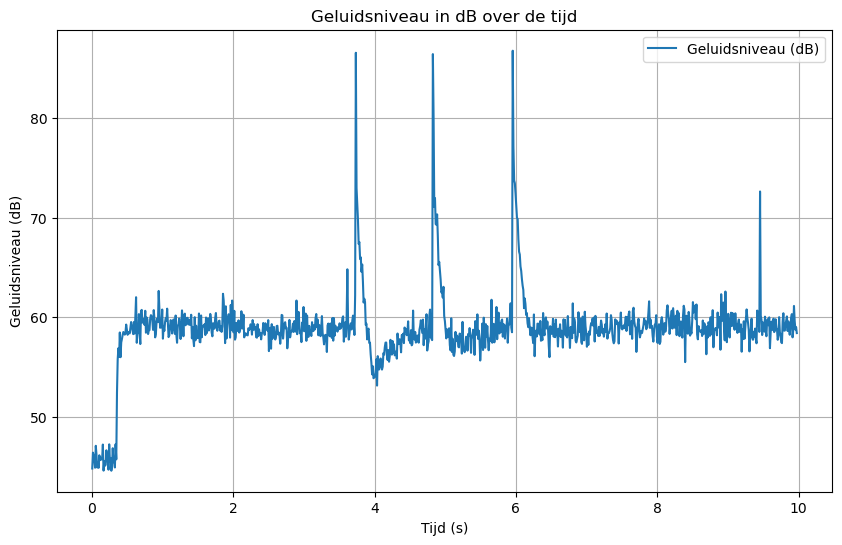

In [305]:
#cel 4 maakt een dB-tijd grafiek
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import butter, filtfilt

# Inlezen van het .wav bestand
sampling_rate, audio_data = wavfile.read(latest_wav)

# Controleer of de audio mono of stereo is en converteer naar mono indien nodig
if len(audio_data.shape) > 1:
    audio_data = np.mean(audio_data, axis=1)

# Stel de begintijd en eindtijd in om de gemiddelde intensiteit te berekenen
t_start = 1  # in seconden
t_end = 9    # in seconden

# Stel de middenfrequentie en bandbreedte van de bandfilter in
center_freq = 10000
bandwidth = 1000

# Ontwerp een bandpass filter
def butter_bandpass(center_freq, bandwidth, fs, order=4):
    nyquist = 0.5 * fs
    low = (center_freq - bandwidth / 2) / nyquist
    high = (center_freq + bandwidth / 2) / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

# Pas het bandpassfilter toe op de audio data
b, a = butter_bandpass(center_freq, bandwidth, sampling_rate)
filtered_audio_data = filtfilt(b, a, audio_data)

# Definieer de referentie-intensiteit in W/m²
I_ref = 10**-5

# Bereken het geluidsniveau in decibel
def intensity_to_decibel(I, I_ref=10**-5):
   
    if I <= 0:
        raise ValueError("Intensiteit moet groter zijn dan 0.")
    return 11.55 * np.log10(I / I_ref)

# Bereken de RMS-waarde en zet om naar dB voor elk segment
segment_duration = 0.01  # segmentduur in seconden
segment_samples = int(segment_duration * sampling_rate)
num_segments = int(len(filtered_audio_data) / segment_samples)

db_levels = []
time_axis = []

for i in range(num_segments):
    segment = filtered_audio_data[i * segment_samples:(i + 1) * segment_samples]
    rms = np.sqrt(np.mean(segment**2))
    db = intensity_to_decibel(rms)
    db_levels.append(db)
    time_axis.append((i + 0.5) * segment_duration)

# Plot het geluidsniveau in dB tegen de tijd
plt.figure(figsize=(10, 6))
plt.plot(time_axis, db_levels, label='Geluidsniveau (dB)')
plt.xlabel('Tijd (s)')
plt.ylabel('Geluidsniveau (dB)')
plt.title('Geluidsniveau in dB over de tijd')
plt.legend()
plt.grid(True)
plt.show()

Nagalmtijd T60 (geschat via T30): 0.62 seconden


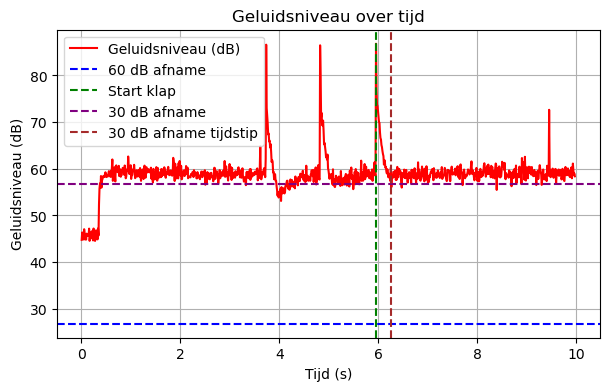

np.float64(86.80211312196835)

In [307]:
#cel 5 geeft de nagalmtijd
import numpy as np
import matplotlib.pyplot as plt

# Gebruik de gegevens uit de eerste cel
time = np.array(time_axis)  # Tijdswaarden uit de vorige cel
L_dB = np.array(db_levels)  # Geluidsniveaus uit de vorige cel

# Zoek de maximale geluidssterkte en het tijdstip ervan
L_max = np.max(L_dB)
t_max = time[np.argmax(L_dB)]

# Definieer de dB-afname niveaus
L_target_60 = L_max - 60
L_target_30 = L_max - 30
L_target_15 = L_max - 15

# Zoek het eerste tijdstip waar het geluidsniveau onder L_target_60 komt, na t_max
t_60 = None
for i in range(len(L_dB)):
    if time[i] > t_max and L_dB[i] <= L_target_60:
        t_60 = time[i]
        break

# Als geen T60 is gevonden, zoek dan T30 en schaal naar T60
if t_60 is not None:
    T_60 = t_60 - t_max
    print(f"Nagalmtijd T60: {T_60:.2f} seconden")
else:
    t_30 = None
    for i in range(len(L_dB)):
        if time[i] > t_max and L_dB[i] <= L_target_30:
            t_30 = time[i]
            break
    
    if t_30 is not None:
        T_30 = t_30 - t_max
        T_60 = 2 * T_30  # Schaal T30 naar T60
        print(f"Nagalmtijd T60 (geschat via T30): {T_60:.2f} seconden")
    else:
        # Als geen T30 is gevonden, zoek dan T15 en schaal naar T60
        t_15 = None
        for i in range(len(L_dB)):
            if time[i] > t_max and L_dB[i] <= L_target_15:
                t_15 = time[i]
                break
        
        if t_15 is not None:
            T_15 = t_15 - t_max
            T_60 = 4 * T_15  # Schaal T20 naar T60
            print(f"Nagalmtijd T60 (geschat via T15): {T_60:.2f} seconden")
        else:
            print("Kon geen 60 dB, 30 dB of 15 dB afname vinden.")

# Geluidsniveau als functie van de tijd plotten
plt.figure(figsize=(7, 4))
plt.plot(time, L_dB, label="Geluidsniveau (dB)", color="red")
plt.axhline(L_max - 60, color="blue", linestyle="--", label="60 dB afname")
plt.axvline(t_max, color="green", linestyle="--", label="Start klap")

if t_60 is not None:
    plt.axvline(t_60, color="orange", linestyle="--", label="60 dB afname tijdstip")
elif t_30 is not None:
    plt.axhline(L_max - 30, color="purple", linestyle="--", label="30 dB afname")
    plt.axvline(t_30, color="brown", linestyle="--", label="30 dB afname tijdstip")
elif t_15 is not None:
    plt.axhline(L_max - 15, color="gray", linestyle="--", label="15 dB afname")
    plt.axvline(t_15, color="black", linestyle="--", label="15 dB afname tijdstip")

plt.xlabel("Tijd (s)")
plt.ylabel("Geluidsniveau (dB)")
plt.title("Geluidsniveau over tijd")
plt.legend()
plt.grid()
plt.show()
L_max

Nagalmtijd T60: 0.62 seconden
Nagalmtijd T30: 0.31 seconden
Nagalmtijd T15: 0.05 seconden


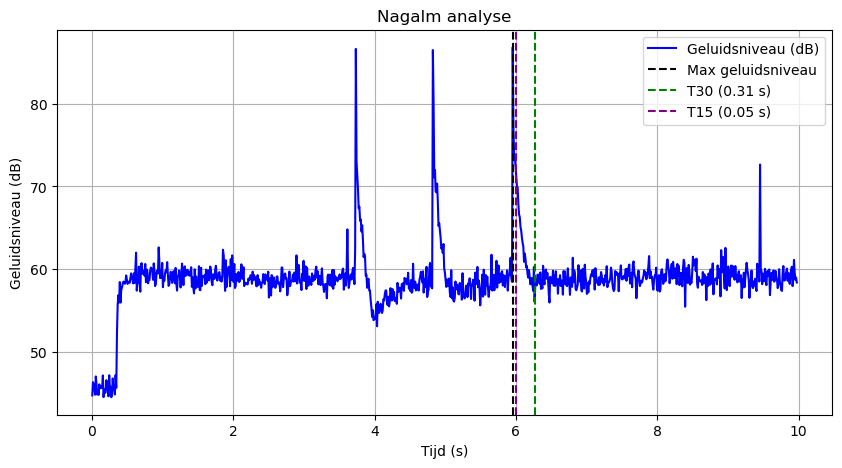

In [309]:
#cel 6, Geeft ook de nagalmtijd als de vorige cel niet goed werkt
import numpy as np
import matplotlib.pyplot as plt

# Gebruik de gegevens uit de eerste cel
time = np.array(time_axis)  # Tijdswaarden uit de vorige cel
L_dB = np.array(db_levels)  # Geluidsniveaus uit de vorige cel

# Zoek de maximale geluidssterkte en het tijdstip ervan
L_max = np.max(L_dB)
t_max = time[np.argmax(L_dB)]

# Definieer de dB-afname niveaus
L_target_60 = L_max - 60
L_target_30 = L_max - 30
L_target_15 = L_max - 15

# Zoek het eerste tijdstip waar het geluidsniveau onder L_target_x komt na t_max
def find_t_decay(target_level):
    for i in range(len(L_dB)):
        if time[i] > t_max and L_dB[i] <= target_level:
            return time[i]
    return None

t_60 = find_t_decay(L_target_60)
t_30 = find_t_decay(L_target_30)
t_15 = find_t_decay(L_target_15)

# Bereken de nagalmtijden indien mogelijk
T_60 = t_60 - t_max if t_60 else None
T_30 = t_30 - t_max if t_30 else None
T_15 = t_15 - t_max if t_15 else None

# Schaal nagalmtijden indien nodig
if T_60 is None:
    if T_30 is not None:
        T_60 = 2 * T_30
    elif T_15 is not None:
        T_60 = 4 * T_15

# Print de gevonden nagalmtijden
if T_60:
    print(f"Nagalmtijd T60: {T_60:.2f} seconden")
if T_30:
    print(f"Nagalmtijd T30: {T_30:.2f} seconden")
if T_15:
    print(f"Nagalmtijd T15: {T_15:.2f} seconden")
if not any([T_60, T_30, T_15]):
    print("Kon geen nagalmtijden vinden.")

# Plot de resultaten
plt.figure(figsize=(10, 5))
plt.plot(time, L_dB, label='Geluidsniveau (dB)', color='blue')
plt.axvline(x=t_max, color='black', linestyle='--', label='Max geluidsniveau')

if t_60:
    plt.axvline(x=t_60, color='red', linestyle='--', label=f'T60 ({T_60:.2f} s)')
if t_30:
    plt.axvline(x=t_30, color='green', linestyle='--', label=f'T30 ({T_30:.2f} s)')
if t_15:
    plt.axvline(x=t_15, color='purple', linestyle='--', label=f'T15 ({T_15:.2f} s)')

plt.xlabel('Tijd (s)')
plt.ylabel('Geluidsniveau (dB)')
plt.title('Nagalm analyse')
plt.legend()
plt.grid()
plt.show()